group testing: 6.25879999986978e-05
93
50
Epoch 0 - Training loss: 2.243912935256958
Epoch 0 - Test loss: 2.1251537799835205
Epoch 1 - Training loss: 1.9138392210006714
Epoch 1 - Test loss: 1.6828237771987915
Epoch 2 - Training loss: 1.5368726253509521
Epoch 2 - Test loss: 1.3738799095153809
Epoch 3 - Training loss: 1.3158971071243286
Epoch 3 - Test loss: 1.20412015914917
Epoch 4 - Training loss: 1.187757968902588
Epoch 4 - Test loss: 1.1081197261810303
Epoch 5 - Training loss: 1.1074515581130981
Epoch 5 - Test loss: 1.0473934412002563
Epoch 6 - Training loss: 1.0513980388641357
Epoch 6 - Test loss: 1.0053932666778564
Epoch 7 - Training loss: 1.0096728801727295
Epoch 7 - Test loss: 0.9759343862533569
Epoch 8 - Training loss: 0.9764101505279541
Epoch 8 - Test loss: 0.9547634720802307
Epoch 9 - Training loss: 0.9493616819381714
Epoch 9 - Test loss: 0.9382596611976624
Epoch 10 - Training loss: 0.9262012839317322
Epoch 10 - Test loss: 0.9232161641120911
Epoch 11 - Training loss: 1.11482989

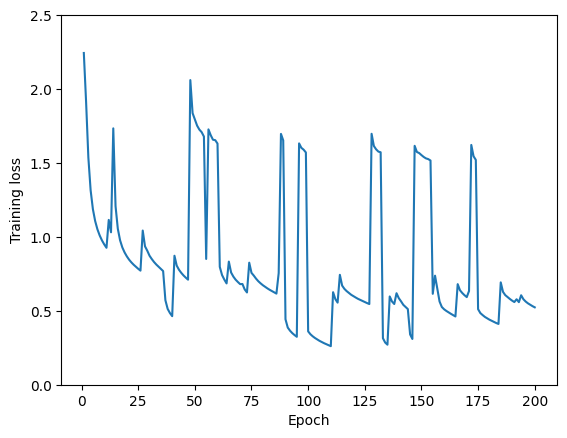

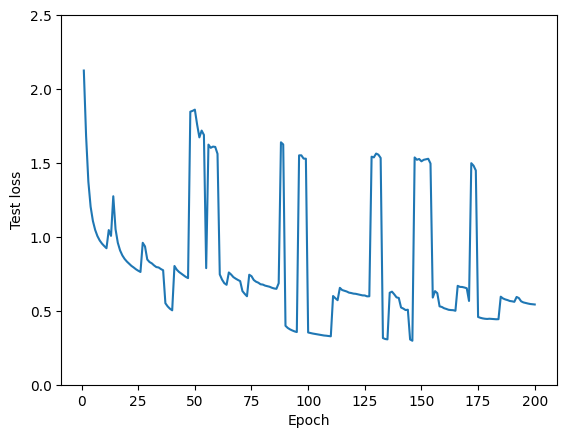

In [1]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 200
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



group testing: 6.898499987073592e-05
74
50
Epoch 0 - Training loss: 2.3056366443634033
Epoch 0 - Test loss: 2.2997353076934814
Epoch 1 - Training loss: 2.3015966415405273
Epoch 1 - Test loss: 2.3029673099517822
Epoch 2 - Training loss: 2.3014719486236572
Epoch 2 - Test loss: 2.3036227226257324
Epoch 3 - Training loss: 2.3007442951202393
Epoch 3 - Test loss: 2.3038501739501953
Epoch 4 - Training loss: 2.3020365238189697
Epoch 4 - Test loss: 2.303317070007324
Epoch 5 - Training loss: 2.3020029067993164
Epoch 5 - Test loss: 2.3033270835876465
Epoch 6 - Training loss: 2.3020071983337402
Epoch 6 - Test loss: 2.303328037261963
Epoch 7 - Training loss: 2.3020076751708984
Epoch 7 - Test loss: 2.3033275604248047
Epoch 8 - Training loss: 2.3038289546966553
Epoch 8 - Test loss: 2.302183151245117
Epoch 9 - Training loss: 2.3011741638183594
Epoch 9 - Test loss: 2.3005759716033936
Epoch 10 - Training loss: 2.301633358001709
Epoch 10 - Test loss: 2.29974102973938
Epoch 11 - Training loss: 2.298166990

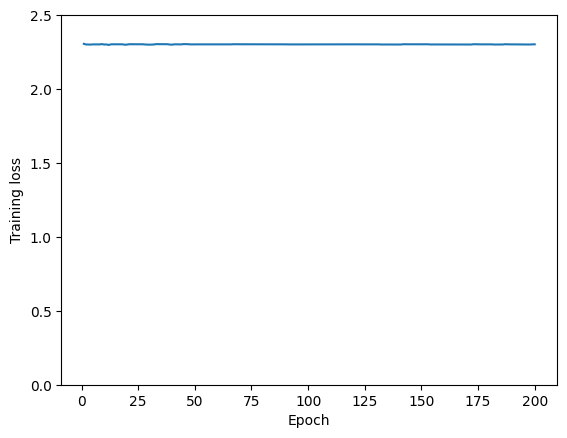

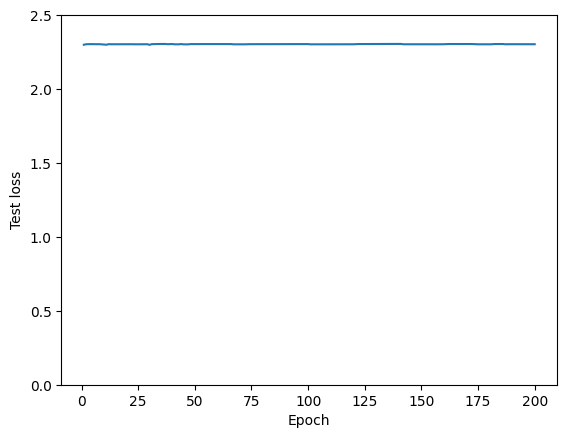

In [2]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 200
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "ones"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



group testing: 7.179200019891141e-05
85
50
Epoch 0 - Training loss: 2.2532854080200195
Epoch 0 - Test loss: 2.1634607315063477
Epoch 1 - Training loss: 1.976778507232666
Epoch 1 - Test loss: 1.7470134496688843
Epoch 2 - Training loss: 1.5950729846954346
Epoch 2 - Test loss: 1.4486515522003174
Epoch 3 - Training loss: 1.5236749649047852
Epoch 3 - Test loss: 1.4129836559295654
Epoch 4 - Training loss: 1.370568871498108
Epoch 4 - Test loss: 1.317261815071106
Epoch 5 - Training loss: 1.2768006324768066
Epoch 5 - Test loss: 1.251095175743103
Epoch 6 - Training loss: 1.2104898691177368
Epoch 6 - Test loss: 1.200993537902832
Epoch 7 - Training loss: 2.1142477989196777
Epoch 7 - Test loss: 1.759232521057129
Epoch 8 - Training loss: 1.5917476415634155
Epoch 8 - Test loss: 1.4345355033874512
Epoch 9 - Training loss: 1.6365376710891724
Epoch 9 - Test loss: 1.3015961647033691
Epoch 10 - Training loss: 1.3035049438476562
Epoch 10 - Test loss: 1.1669505834579468
Epoch 11 - Training loss: 0.995636940

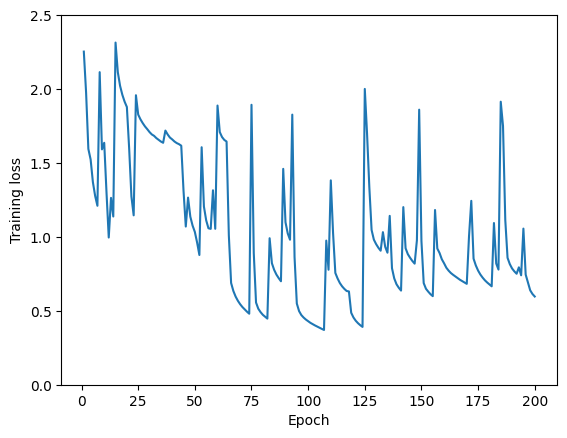

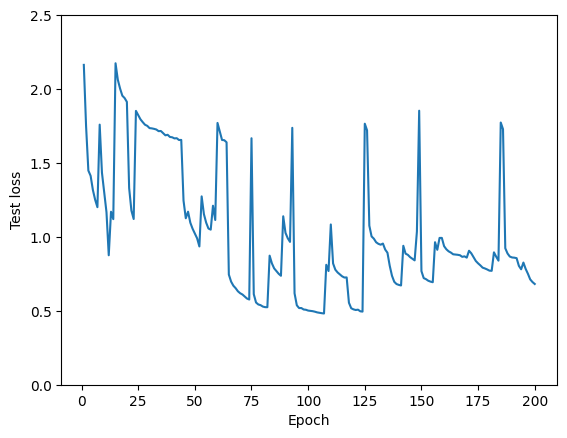

In [3]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 200
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "latest"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

